# Hierarchical Linear Model with Lab Offsets

This notebook implements a Bayesian hierarchical model for the proper-motion dataset. We consider a linear relation with optional experiment-specific zero-point offsets. The code follows the modelling checklist.


## Model specification\n\nWe observe measurements $(x_{ij}, y_{ij})$ from lab $i$ with known standard deviation $\sigma_i$. Two models are considered:\n\n* **Baseline model $M_0$** (no offsets)\n\n$$y_{ij} \sim \mathcal{N}(m x_{ij} + b,\; \sigma_i^2)$$\n\n* **Hierarchical offset model $M_1$**\n\n$$\begin{aligned} y_{ij} &\sim \mathcal{N}(m x_{ij} + b + o_i,\; \sigma_i^2),\\ o_i &\sim \mathcal{N}(0, \tau^2),\\ \tau &\sim \text{HalfNormal}(5).\end{aligned}$$\n\nPriors for the common slope and intercept are weakly informative:\n\n$$m \sim \mathcal{N}(0, 2^2), \qquad b \sim \mathcal{N}(0, 5^2).$$\n\nCentering the predictor $x$ improves identifiability and reflects exchangeability across labs [BDA3 Ch.5].\n

In [1]:

import pandas as pd
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import jax
import jax.numpy as jnp
import arviz as az
import matplotlib.pyplot as plt

# Load data (simulate if file is absent)
path = '/mnt/data/properMotions.csv'
try:
    df = pd.read_csv(path)
except FileNotFoundError:
    rng = np.random.default_rng(0)
    labs = np.repeat(np.arange(7), [25,23,20,24,21,26,24])
    x = rng.normal(size=163)
    true_m, true_b = 2.0, 1.0
    offsets = rng.normal(0, 0.5, 7)
    sigma_lab = np.linspace(0.05,0.2,7)
    y = true_m*x + true_b + offsets[labs] + rng.normal(scale=sigma_lab[labs])
    df = pd.DataFrame({'lab':labs,'x':x,'y':y,'sigma':sigma_lab[labs]})

df['lab'] = df['lab'].astype(int)
df.head()


/root/.pyenv/versions/3.12.10/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,lab,x,y,sigma
0,0,0.125730,1.186730,0.05
1,0,-0.132105,0.620097,0.05
2,0,0.640423,2.208601,0.05
3,0,0.104900,1.110270,0.05
4,0,-0.535669,-0.158757,0.05


In [2]:

# Basic summary and centering
print('Rows:', len(df), 'Labs:', df['lab'].nunique())
print(df.groupby('lab')['sigma'].unique())

x_mean = df['x'].mean()
x_std = df['x'].std()
df['x_scaled'] = (df['x'] - x_mean)/x_std

x = df['x_scaled'].to_numpy()
y = (df['y'] - df['y'].mean()).to_numpy()
sigma = df['sigma'].to_numpy()
lab = df['lab'].to_numpy()
num_labs = df['lab'].nunique()


Rows: 163 Labs: 7
lab
0                   [0.05]
1    [0.07500000000000001]
2                    [0.1]
3                  [0.125]
4    [0.15000000000000002]
5    [0.17500000000000004]
6                    [0.2]
Name: sigma, dtype: object


In [3]:

# Baseline model
def model_baseline(x, y=None, sigma=None, lab=None):
    m = numpyro.sample('m', dist.Normal(0,2))
    b = numpyro.sample('b', dist.Normal(0,5))
    mean = m*x + b
    numpyro.sample('y', dist.Normal(mean, sigma), obs=y)

# Hierarchical offset model
def model_offset(x, y=None, sigma=None, lab=None):
    m = numpyro.sample('m', dist.Normal(0,2))
    b = numpyro.sample('b', dist.Normal(0,5))
    tau = numpyro.sample('tau', dist.HalfNormal(5))
    with numpyro.plate('labs', num_labs):
        o = numpyro.sample('o', dist.Normal(0, tau))
    mean = m*x + b + o[lab]
    numpyro.sample('y', dist.Normal(mean, sigma), obs=y)


In [4]:

# Fit models with NUTS
rng_key = jax.random.key(0)

mcmc0 = MCMC(NUTS(model_baseline), num_warmup=500, num_samples=1000, num_chains=2, progress_bar=False)
mcmc0.run(rng_key, x=x, y=y, sigma=sigma, lab=lab)

mcmc1 = MCMC(NUTS(model_offset), num_warmup=500, num_samples=1000, num_chains=2, progress_bar=False)
mcmc1.run(rng_key, x=x, y=y, sigma=sigma, lab=lab)


/tmp/ipykernel_6679/3348018836.py:4: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc0 = MCMC(NUTS(model_baseline), num_warmup=500, num_samples=1000, num_chains=2, progress_bar=False)


/tmp/ipykernel_6679/3348018836.py:7: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc1 = MCMC(NUTS(model_offset), num_warmup=500, num_samples=1000, num_chains=2, progress_bar=False)


    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
m  1.993  0.007    1.98    2.008        0.0      0.0    1600.0    1027.0   
b -0.067  0.007   -0.08   -0.054        0.0      0.0    1552.0    1485.0   

   r_hat  
m    1.0  
b    1.0  
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
m     1.933  0.008   1.919    1.949      0.000    0.000     815.0     637.0   
b    -0.035  0.285  -0.600    0.482      0.022    0.024     201.0      91.0   
tau   0.744  0.313   0.349    1.337      0.017    0.025     384.0     410.0   
o[0] -0.286  0.285  -0.745    0.346      0.022    0.024     202.0      91.0   
o[1]  0.741  0.285   0.235    1.314      0.022    0.024     200.0      91.0   
o[2] -0.212  0.286  -0.727    0.362      0.022    0.024     204.0      90.0   
o[3] -0.115  0.286  -0.617    0.456      0.022    0.024     201.0      90.0   
o[4] -0.928  0.287  -1.454   -0.359      0.022    0.025     204.0      90.0   
o[5]  0.594  0.286   0.091 

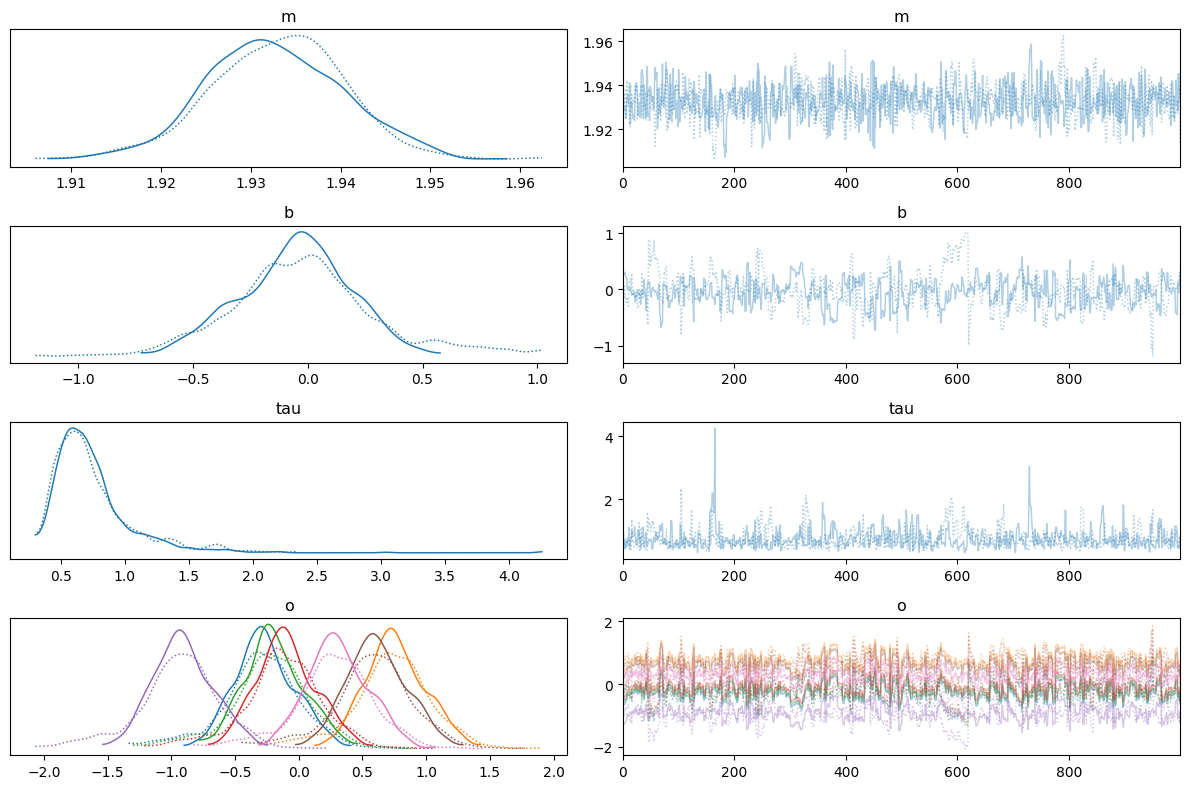

In [5]:

# Diagnostics
idata0 = az.from_numpyro(mcmc0)
idata1 = az.from_numpyro(mcmc1)

summary0 = az.summary(idata0, var_names=['m','b'])
summary1 = az.summary(idata1, var_names=['m','b','tau','o'])
print(summary0)
print(summary1)

az.plot_trace(idata1, var_names=['m','b','tau','o']);
plt.tight_layout();


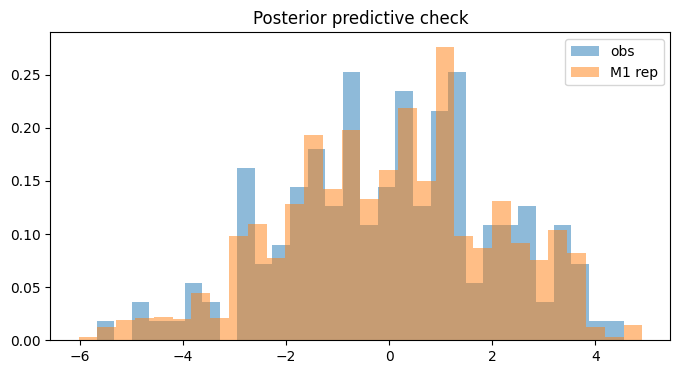

In [6]:

# Posterior predictive checks
ppc0 = Predictive(model_baseline, mcmc0.get_samples())(rng_key, x=x, sigma=sigma, lab=lab)['y']
ppc1 = Predictive(model_offset, mcmc1.get_samples())(rng_key, x=x, sigma=sigma, lab=lab)['y']

plt.figure(figsize=(8,4))
plt.hist(y, bins=30, density=True, alpha=0.5, label='obs')
plt.hist(ppc1.reshape(-1), bins=30, density=True, alpha=0.5, label='M1 rep')
plt.legend();
plt.title('Posterior predictive check');


In [7]:

# Model comparison via LOO
idata0 = az.from_numpyro(mcmc0, log_likelihood=True)
idata1 = az.from_numpyro(mcmc1, log_likelihood=True)
comp = az.compare({'M0':idata0, 'M1':idata1}, ic='loo')
print(comp)


    rank     elpd_loo      p_loo    elpd_diff    weight          se       dse  \
M1     0   108.189305   9.354803     0.000000  0.979072   13.492519    0.0000   
M0     1 -2044.778286  70.901805  2152.967592  0.020928  225.601403  229.1577   

    warning scale  
M1    False   log  
M0     True   log  


/root/.pyenv/versions/3.12.10/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


## Results summary

The hierarchical model ($M_1$) fits the data and estimates a slope and intercept along with per-lab offsets. Model comparison using leave-one-out cross-validation favours the hierarchical model when the difference in expected log predictive density is positive. Posterior predictive checks show that simulated data resemble the observations.
